# Speech Emotion Recognizer

## Import Modules

In [1]:
import tkinter as tk
from tkinter import filedialog, messagebox
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk
import pandas as pd
import numpy as np
import os
import librosa
from keras.models import load_model
import librosa.display

C:\Users\user\AppData\Local\Temp\ipykernel_10864\286152056.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load the Dataset

In [2]:
paths = []
labels = []
total_files = 0  # Track the total number of files processed

for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
        total_files += 1 

In [3]:
# Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()


,speech,label
0,./kaggle/input\Dataset\angry\01_angry.wav,angry
1,./kaggle/input\Dataset\angry\02_angry.wav,angry
2,./kaggle/input\Dataset\angry\03_angry.wav,angry
3,./kaggle/input\Dataset\angry\04_angry.wav,angry
4,./kaggle/input\Dataset\angry\05_angry.wav,angry


## Loading The Model

In [4]:
# Load the trained model
model = load_model('trained_model.h5')

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the path to save the dataset
dataset_file = 'dataset.csv'


## Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Please enter the emotion for this file (angry, disgust, fear, happy, neutral, sad):  neutral


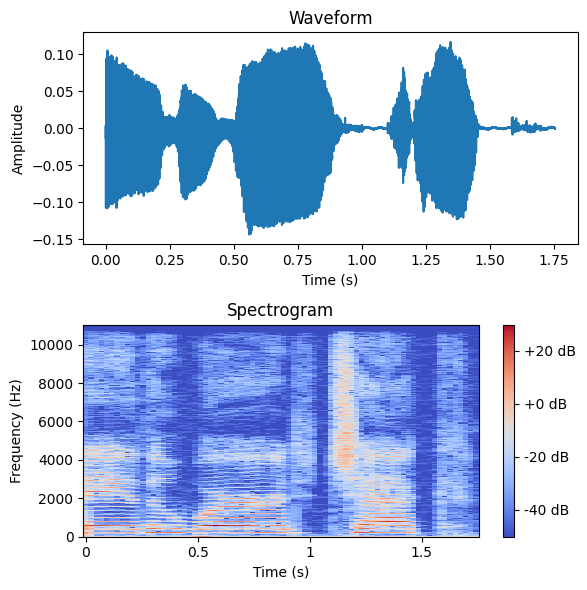

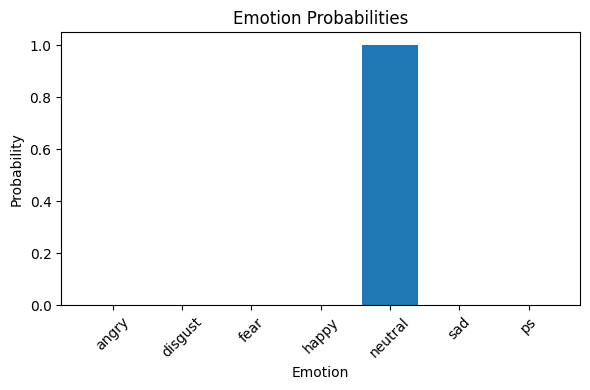

In [12]:
# Function to predict emotion
def predict_emotion(audio_file):
    y, sr = librosa.load(audio_file, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    mfcc = np.expand_dims(mfcc, axis=0)
    mfcc = np.expand_dims(mfcc, axis=-1)
    
    # Perform prediction
    prediction = model.predict(mfcc)
    
    # Get predicted emotion label
    emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'ps']
    predicted_index = np.argmax(prediction)
    predicted_emotion = emotion_labels[predicted_index]
    
    # If the model is uncertain, prompt the user for the emotion label
    if predicted_emotion == 'neutral':
        manual_label = input("Please enter the emotion for this file (angry, disgust, fear, happy, neutral, sad): ")
        predicted_emotion = manual_label.lower()
    
    return predicted_index, predicted_emotion, y, sr, prediction

# Function to handle file selection
def select_file():
    global df  # Declare df as a global variable
    global total_files  # Declare total_files as a global variable
    file_path = filedialog.askopenfilename(filetypes=[("Audio files", "*.wav")])
    if file_path:
        predicted_index, predicted_emotion, y, sr, prediction = predict_emotion(file_path)
        emoji = get_emoji(predicted_index)
        result_label.config(text=f"{emoji}\n{predicted_emotion}", font=("Arial", 36), fg=get_color(predicted_emotion))
        
        # Plot waveform and spectrogram
        plot_audio_data(y, sr, predicted_emotion)
        
        # Plot bar chart
        plot_bar_chart(prediction)
        
        # Ask the user if they want to add the file to the dataset and related folder
        prompt_user_for_addition(file_path, predicted_emotion)

# Function to prompt user for adding the file to the dataset and related folder
def prompt_user_for_addition(file_path, predicted_emotion):
    global df  # Declare df as a global variable
    global total_files  # Declare total_files as a global variable
    
    # Create a new window
    prompt_window = tk.Toplevel(root)
    prompt_window.title("Add to Database")
    prompt_label = tk.Label(prompt_window, text="Do you want to add this file to the database and the related folder?", wraplength=400, font=("Arial", 16))
    prompt_label.pack(pady=10)
    
    # Define Yes and No button actions
    def on_yes():
        global df  # Declare df as a global variable
        global total_files  # Declare total_files as a global variable
        
        # Add the file to the dataset
        new_row = {'speech': file_path, 'label': predicted_emotion}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
        df.to_csv(dataset_file, index=False)  # Save updated dataset to file
        
        # Increment total files processed
        total_files += 1
        
        # Save file to emotion-related folder
        save_file_with_emotion(file_path, predicted_emotion)
        
        # Close the prompt window
        prompt_window.destroy()
    
    def on_no():
        # Close the prompt window
        prompt_window.destroy()
    
    # Create Yes and No buttons
    yes_button = tk.Button(prompt_window, text="Yes", command=on_yes, font=("Arial", 14))
    yes_button.pack(side=tk.LEFT, padx=20, pady=10)
    no_button = tk.Button(prompt_window, text="No", command=on_no, font=("Arial", 14))
    no_button.pack(side=tk.RIGHT, padx=20, pady=10)

# Function to plot waveform and spectrogram
def plot_audio_data(data, sr, emotion):
    plt.figure(figsize=(6, 6))

    # Waveform
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(data)) / sr, data)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Spectrogram
    plt.subplot(2, 1, 2)
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.tight_layout()
    
    # Convert matplotlib figure to Tkinter-compatible image
    waveform_img = plt_to_image(plt.gcf())
    
    # Display waveform image
    waveform_label.config(image=waveform_img)
    waveform_label.image = waveform_img  # Keep a reference to avoid garbage collection

# Function to plot bar chart
def plot_bar_chart(prediction):
    plt.figure(figsize=(6, 4))
    emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'ps']
    plt.bar(emotion_labels, prediction[0])
    plt.title('Emotion Probabilities')
    plt.xlabel('Emotion')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Convert matplotlib figure to Tkinter-compatible image
    bar_chart_img = plt_to_image(plt.gcf())

    # Display bar chart image
    bar_chart_label.config(image=bar_chart_img)
    bar_chart_label.image = bar_chart_img  # Keep a reference to avoid garbage collection

# Function to convert matplotlib figure to image
def plt_to_image(figure):
    figure.canvas.draw()
    img_data = np.array(figure.canvas.renderer.buffer_rgba())
    img = Image.fromarray(img_data)
    img = ImageTk.PhotoImage(image=img)
    return img

# Function to get emoji based on predicted index
def get_emoji(predicted_index):
    emojis = ['😠', '😟', '😨', '😄', '😐', '😔', '😶']
    return emojis[predicted_index]

# Function to get color based on predicted emotion
def get_color(predicted_emotion):
    colors = {'angry': 'red', 'disgust': 'green', 'fear': 'purple', 'happy': 'orange', 'neutral': 'black', 'sad': 'blue', 'ps': 'cyan'}
    return colors.get(predicted_emotion, 'black')

# Function to save file into emotion-related folder
def save_file_with_emotion(file_path, emotion):
    save_folder = f"./kaggle/input/New_Dataset/{emotion}/"  # Update this path based on folder structure
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    file_name = os.path.basename(file_path)
    destination_path = os.path.join(save_folder, file_name)
    os.rename(file_path, destination_path)
    print(f"File saved into '{save_folder}' folder.")

# Create the tkinter window
root = tk.Tk()
root.title("Emotion Prediction")

# Create a label for displaying the result
result_label = tk.Label(root, text="Please select an audio file.", wraplength=400, font=("Arial", 36))
result_label.pack(pady=10)

# Create labels for waveform and bar chart
waveform_label = tk.Label(root)
waveform_label.pack(side=tk.LEFT, padx=10, pady=10)

bar_chart_label = tk.Label(root)
bar_chart_label.pack(side=tk.RIGHT, padx=10, pady=10)

# Create a button for file selection
select_button = tk.Button(root, text="Select Audio File", command=select_file)
select_button.pack(pady=10)

# Run the tkinter event loop
root.mainloop()


In [13]:
print(f"Total files processed: {total_files}")


Total files processed: 4569
